# Benchmarking Behavior Planners in BARK

This notebook the benchmarking workflow of BARK.

Systematically benchmarking behavior consists of
1. A reproducable set of scenarios (we call it **BenchmarkDatabase**)
2. Metrics, which you use to study the performance (we call it **Evaluators**)
3. The behavior model(s) under test

Our **BenchmarkRunner** can then run the benchmark and produce the results.

In [6]:
import os
import matplotlib.pyplot as plt
from IPython.display import Video

from load.benchmark_database import BenchmarkDatabase
from serialization.database_serializer import DatabaseSerializer
from modules.benchmark.benchmark_runner import BenchmarkRunner, BenchmarkConfig, BenchmarkResult
from modules.benchmark.benchmark_analyzer import BenchmarkAnalyzer

from modules.runtime.commons.parameters import ParameterServer

from modules.runtime.viewer.matplotlib_viewer import MPViewer
from modules.runtime.viewer.video_renderer import VideoRenderer


from bark.models.behavior import BehaviorIDMClassic, BehaviorConstantVelocity

# Database
The benchmark database provides a reproducable set of scenarios.
A scenario get's created by a ScenarioGenerator (we have a couple of them). The scenarios are serialized into binary files (ending `.bark_scenarios`) and packed together with the map file and the parameter files into a `.zip`-archive. We call this zipped archive a relase, which can be published at Github, or processed locally.

## We will first start with the DatabaseSerializer

The **DatabaseSerializer** recursively serializes all scenario param files sets
 within a folder.

process the database directory

In [7]:
#dbs = DatabaseSerializer(test_scenarios=4, test_world_steps=5, num_serialize_scenarios=10)
dbs = DatabaseSerializer(test_scenarios=1, test_world_steps=10, num_serialize_scenarios=1)
dbs.process("../../../benchmark_database/data/database1")
local_release_filename = dbs.release(version="tutorial")

print('Filename:', local_release_filename)

INFO:root:Testing 40per_variation with seed 2000 from generator ConfigurableScenarioGeneration
INFO:root:Running scenario 0 of 1 in set 40per_variation
INFO:root:Testing 20per_variation with seed 2000 from generator ConfigurableScenarioGeneration
INFO:root:Running scenario 0 of 1 in set 20per_variation
INFO:root:The following list of files will be released:
INFO:root:/maps/city_highway_straight.xodr/city_highway_straight.xodr
INFO:root:/scenario_sets/highway_merging/set_info_40per_variation/set_info_40per_variation
INFO:root:/scenario_sets/highway_merging/40per_variation.json/40per_variation.json
INFO:root:/scenario_sets/highway_merging/20per_variation_scenarios1_seed2000.bark_scenarios/20per_variation_scenarios1_seed2000.bark_scenarios
INFO:root:/scenario_sets/highway_merging/40per_variation_scenarios1_seed2000.bark_scenarios/40per_variation_scenarios1_seed2000.bark_scenarios
INFO:root:/scenario_sets/highway_merging/set_info_20per_variation/set_info_20per_variation
INFO:root:/scenario

Filename: ../../../benchmark_database/data/benchmark_database_tutorial.zip


Then reload to test correct parsing

In [8]:
db = BenchmarkDatabase(database_root=local_release_filename)
scenario_generation, _ = db.get_scenario_generator(scenario_set_id=0)

for scenario_generation, _ in db:
  print('Scenario: ', scenario_generation)

INFO:root:extracting zipped-database ../../../benchmark_database/data/benchmark_database_tutorial.zip to temporary directory /tmp/bark_extracted_databases/fe8e0a06-a114-414c-bdc6-c8d3e8634fb4
INFO:root:Found info dict set_info_40per_variation
INFO:root:Found info dict set_info_20per_variation
INFO:root:The following scenario sets are available
INFO:root:
                    GeneratorName  NumScenarios                                             Params    Seed                                         Serialized          SetName
0  ConfigurableScenarioGeneration           1.0  scenario_sets/highway_merging/40per_variation....  2000.0  scenario_sets/highway_merging/40per_variation_...  40per_variation
1  ConfigurableScenarioGeneration           1.0  scenario_sets/highway_merging/20per_variation....  2000.0  scenario_sets/highway_merging/20per_variation_...  20per_variation


Scenario:  <modules.runtime.scenario.scenario_generation.scenario_generation.ScenarioGeneration object at 0x7f1f4fdd8590>
Scenario:  <modules.runtime.scenario.scenario_generation.scenario_generation.ScenarioGeneration object at 0x7f1f5903c090>


## Evaluators

Evaluators allow to calculate a boolean, integer or real-valued metric based on the current simulation world state.

The current evaluators available in BARK are:
- StepCount: returns the step count the scenario is at.
- GoalReached: checks if a controlled agent’s Goal Definitionis satisfied.
- DrivableArea: checks whether the agent is inside its RoadCorridor.
- Collision(ControlledAgent): checks whether any agent or only the currently controlled agent collided

Let's now map those evaluators to some symbols, that are easier to interpret.

In [9]:
evaluators = {"success" : "EvaluatorGoalReached", \
              "collision" : "EvaluatorCollisionEgoAgent", \
              "max_steps": "EvaluatorStepCount"}

We will now define the terminal conditions of our benchmark. We state that a scenario ends, if
- a collision occured
- the number of time steps exceeds the limit
- the definition of success becomes true (which we defined to reaching the goal, using EvaluatorGoalReached)

In [10]:
terminal_when = {"collision" :lambda x: x, \
                 "max_steps": lambda x : x>10, \
                 "success" : lambda x: x}

# Behaviors Under Test
Let's now define the Behaviors we want to compare. We will compare IDM with Constant Velocity, but we could also compare two different parameter sets for IDM. 

In [11]:
params = ParameterServer() 
behaviors_tested = {"IDM": BehaviorIDMClassic(params), "Const" : BehaviorConstantVelocity(params)}

# Benchmark Runner

The BenchmarkRunner allows to evaluate behavior models with different parameter configurations over the entire benchmarking database.

In [12]:
benchmark_runner = BenchmarkRunner(benchmark_database=db,\
                                   evaluators=evaluators,\
                                   terminal_when=terminal_when,\
                                   behaviors=behaviors_tested,\
                                   log_eval_avg_every=10)

result = benchmark_runner.run(maintain_history=True)

INFO:BenchmarkRunner:Running config idx 0/3: Scenario 0 of set "40per_variation" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 1/3: Scenario 0 of set "20per_variation" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 2/3: Scenario 0 of set "40per_variation" for behavior "Const"
INFO:BenchmarkRunner:Running config idx 3/3: Scenario 0 of set "20per_variation" for behavior "Const"


We will now dump the files, to allow them to be postprocessed later.

In [13]:
result.dump(os.path.join("./benchmark_results.pickle"))


INFO:root:Saved BenchmarkResult to /tmp/bark_extracted_databases/fe8e0a06-a114-414c-bdc6-c8d3e8634fb4/benchmark_results.pickle


# Benchmark Results

Benchmark results contain
- the evaluated metrics of each simulation run, as a Panda Dataframe
- the world state of every simulation (optional)

In [14]:
result_loaded = BenchmarkResult.load(os.path.join("./benchmark_results.pickle"))

We will now first analyze the dataframe.

In [21]:
df = result_loaded.get_data_frame()

df.head()

,Terminal,behavior,collision,config_idx,max_steps,scen_idx,scen_set,step,success
0,[max_steps],IDM,False,0,11,0,40per_variation,10,False
1,[max_steps],IDM,False,1,11,0,20per_variation,10,False
2,[max_steps],Const,False,2,11,0,40per_variation,10,False
3,[max_steps],Const,False,3,11,0,20per_variation,10,False


# Benchmark Analyzer

The benchmark analyzer allows to filter the results to show visualize what really happened. These filters can be set via a dictionary with lambda functions specifying the evaluation criteria which must be fullfilled.

A config is basically a simulation run, where step size, controlled agent, terminal conditions and metrics have been defined.

Let us first load the results into the BenchmarkAnalyzer and then filter the results.

In [16]:
analyzer = BenchmarkAnalyzer(benchmark_result=result_loaded)


configs_idm = analyzer.find_configs(criteria={"behavior": lambda x: x=="IDM", "success": lambda x : not x})
configs_const = analyzer.find_configs(criteria={"behavior": lambda x: x=="Const", "success": lambda x : not x})

We will now create a video from them. We will use Matplotlib Viewer and render everything to a video.

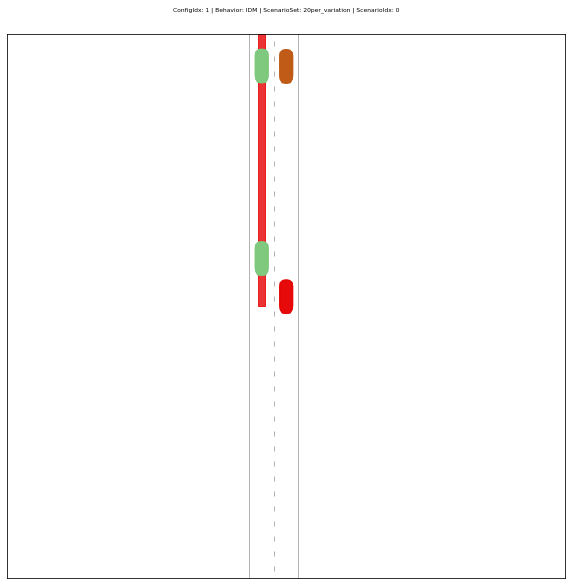

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
sim_step_time=5

params2 = ParameterServer()

fig = plt.figure(figsize=[10, 10])
viewer = MPViewer(params=params2, y_length = 80, enforce_y_length=True, enforce_x_length=False,\
                  follow_agent_id=True, axis=fig.gca())
video_exporter = VideoRenderer(renderer=viewer, world_step_time=sim_step_time)

analyzer.visualize(viewer = video_exporter, configs_idx_list=configs_idm[1:3], \
                  real_time_factor=10, fontsize=6)
                   
video_exporter.export_video(filename="./tutorial_video")


In [18]:
Video("./tutorial_video.mp4")